In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

def Connectivity(counts):
    counts = np.array(counts)
    s = counts.sum()
    return (s - counts.size) / (s - 1)


@dataclass
class ClusterProperties:
    """array contains statistics of different simulations"""
    maximum: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
    minimum: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
    median: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
    mean: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
    spread: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
    connectivity: np.ndarray = field(default_factory = lambda: np.empty(0, dtype=np.float64))
        
        
def AddClusterProperties(props: ClusterProperties, counts):
    props.maximum = np.append(props.maximum, np.max(counts))
    props.minimum = np.append(props.minimum, np.min(counts))
    props.median = np.append(props.median, np.median(counts))
    props.mean = np.append(props.mean, np.mean(counts))
    props.spread = np.append(props.spread, np.max(counts) - np.min(counts))
    props.connectivity = np.append(props.connectivity, Connectivity(counts))
    
    
def PrintClusterProps(counts, skipped=None):
    print(f"#Clusters: {len(counts)}")
    print(f"Max: {np.max(counts)}")
    print(f"Min: {np.min(counts)}")
    print(f"Median: {np.median(counts)}")
    print(f"Mean: {np.mean(counts):.2f}")
    print(f"Std: {np.std(counts):.2f}")
    print(f"Spread: {np.max(counts) - np.min(counts)}")
    print(f"Connectivity: {Connectivity(counts):.3f}")
    if skipped:
        print(f"Skipped: {len(skipped)}")

file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
file = "../data/avantgardeGoal/100k/data_improved_avantgarde-uniform_affinity-uniform_goal-uniform_100.csv"
file = "../data/distributions/agent_data_1000steps_a-normal-10-04.csv"

columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)


In [123]:
beta_dist_path = "../data/distributions/beta/"

def find_between(s, start, end):
    return (s.split(start))[1].split(end)[0]

@dataclass
class BetaPDF:
    # definition see WIKI
    mean: float
    alpha: float
    beta: float

def GetBetaPDFFromFileName(fname):
    a = float(find_between(fname, "a-", "_"))
    b = float(find_between(fname, "b-", "_"))
    m = float(find_between(fname, "m-", ".csv"))
    return BetaPDF(m, a, b)
        
beta_files = []
for file in os.listdir(beta_dist_path):
    betaPdf = GetBetaPDFFromFileName(file)
    if "agent_data" in file:
        beta_files.append((file, betaPdf))

In [3]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-02.csv"
#file = "../data/constant_avantgarde/agent_data_800steps_1.csv"
#file = "../data/simplified/agent_data_uniform.csv"
data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"])

In [9]:
np.unique(data.seed)

array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177,
       178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190,
       191, 192, 193, 194, 195, 196, 197, 198, 199, 200], dtype=int64)

In [10]:
LAST_STEP = 1000

sample = data.query("seed == 100")
grid = Grid(Avantgarde(sample, LAST_STEP))

In [5]:
data

,step,id,affinity,avantgarde,affinityGoal,seed
0,0,1,0.660911,0.268373,0.190313,100
1,0,2,0.645691,0.357697,0.967600,100
2,0,3,0.972755,0.479214,0.526845,100
3,0,4,0.523990,0.727542,0.172707,100
4,0,5,0.199381,0.577390,0.893169,100
...,...,...,...,...,...,...
2019995,1000,9996,0.461939,0.016985,0.770322,200
2019996,1000,9997,0.485050,0.767882,0.183342,200
2019997,1000,9998,0.499483,0.087925,0.791582,200
2019998,1000,9999,0.508080,0.455917,0.849198,200


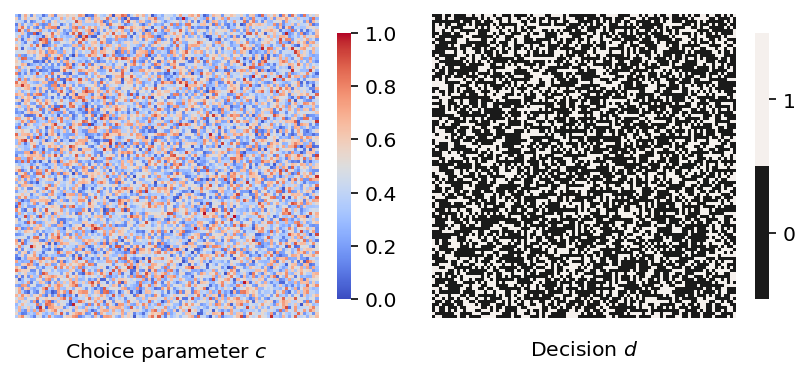

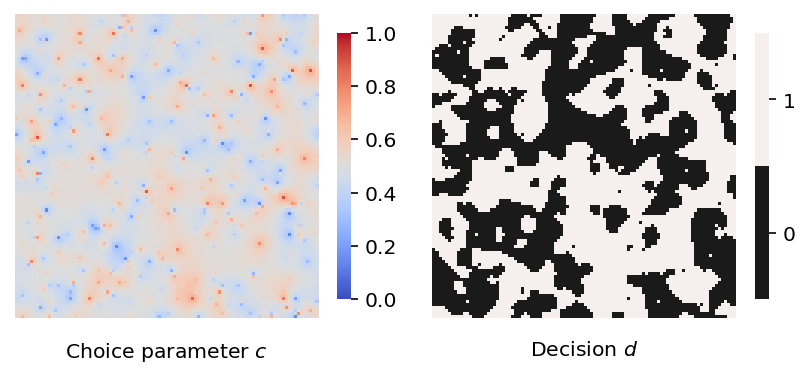

In [93]:
file, dist = beta_files[2]

sample = LoadSimulation(beta_dist_path + file, columns=columns).query("seed == 100")
ShowState(Grid(Avantgarde(sample, 0)))
ShowState(Grid(Choice(sample, 100)))

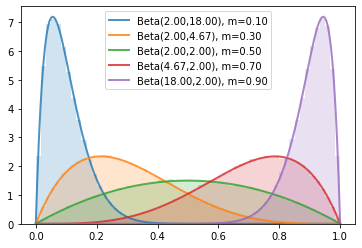

In [127]:
from scipy.stats import beta

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

beta_files.sort(key = lambda x: x[1].mean)

for (file, dist), color in zip(beta_files[1::4], colors):
    sample = LoadSimulation(beta_dist_path + file, columns=columns)
    nbins = 60
    bins = np.linspace(0.0, 1.0, nbins+1)

    counts = []
    for seed in sample.get("seed").unique()[:10]:
        selection = sample.query("seed == @seed")
        avantgarde_ = selection.get("avantgarde")
        selection_counts, _ = np.histogram(avantgarde_, bins) 
        counts.append(selection_counts)
    counts = np.array(counts)

    x = np.linspace(0.0, 1.0, 200)
    plt.plot(x, beta.pdf(x, dist.alpha, dist.beta), 
             lw=2, alpha=0.8, color=color, 
             label=f'Beta({dist.alpha:.2f},{dist.beta:.2f}), m={dist.mean:.2f}')
    
    density = counts / (counts.sum(axis=1)[:, None] * np.diff(bins))
    plt.stairs(density.mean(axis=0), bins, 
               fill=True, alpha=0.2, color=color)
    
    
plt.legend() 
plt.show()

In [107]:
counts.shape

(11, 40)

In [6]:
islands = np.digitize(Grid(Choice(sample, 0)), bins=np.arange(0, 1, 0.5))

counts, skipped = CountSizesStrong(islands, skip_size=0, corner_neighbours=False)
PrintClusterProps(counts[1], skipped)

#Clusters: 3473
Max: 23
Min: 1
Median: 1.0
Mean: 1.43
Std: 1.67
Spread: 22
Connectivity: 0.301


In [233]:
islands

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [2, 2, 1, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]], dtype=int64)

In [65]:
def AddDistribution(distribution, file, mDict, final_step=1000):
    if distribution in mDict.keys():
        print("Distribution %s already existent." % distribution)
        return
    
    if not os.path.exists(file):
        print("File %s not found." % file)
        return
    
    _data = LoadSimulation(file, columns=columns)

    keys = [*range(100, 200)]

    # init cluster props
    positive_props = ClusterProperties()
    negative_props = ClusterProperties()

    for j, key in enumerate(keys):
        _sample = _data.query("seed == @key")
        # >--- get cluster sizes
        grid_data = Grid(Choice(_sample, final_step))
        labeled_data = np.digitize(grid_data, bins=BINARY_CLUSTER_BINS)
        clusters, _ = CountSizes(labeled_data, skip_size=0, corner_neighbours=True) # CountSizesStrong
        # ---<

        # save data
        AddClusterProperties(positive_props, clusters[1])
        AddClusterProperties(negative_props, clusters[2])
    
    mDict[distribution] = dict()
    mDict[distribution]["+"] = positive_props
    mDict[distribution]["-"] = negative_props

In [68]:
def AddDistributionConstantAvantgarde(distribution, a, path, mDict, final_step=800):
    if distribution in mDict.keys():
        print("Distribution %s already existent." % distribution)
        return
    
#     if not os.path.exists(file):
#         print("File %s not found." % file)
#         return
    
    #_data = LoadSimulation(file, columns=columns)

    keys = [*range(1, 24)]

    # init cluster props
    positive_props = ClusterProperties()
    negative_props = ClusterProperties()

    for j, key in enumerate(keys):
        file = f"{path}agent_data_800steps_{key}.csv"
        _data = LoadSimulation(file, columns=["step", "id", "avantgarde", "affinity", "affinityGoal"])
        _sample = _data.query("avantgarde == @a")
        
        #_sample = _data.query("seed == @key")
        # >--- get cluster sizes
        grid_data = Grid(Choice(_sample, final_step))
        labeled_data = np.digitize(grid_data, bins=BINARY_CLUSTER_BINS)
        clusters, _ = CountSizes(labeled_data, skip_size=0, corner_neighbours=True)
        # ---<

        # save data
        AddClusterProperties(positive_props, clusters[1])
        AddClusterProperties(negative_props, clusters[2])
    
    mDict[distribution] = dict()
    mDict[distribution]["+"] = positive_props
    mDict[distribution]["-"] = negative_props

In [8]:
path = "../data/distributions/"

def AddDistFile(files, file, dist):
    files.append((path + file, dist))

In [107]:
path = "../data/constant_avantgarde/"
for a in range(0, 11):
    a = np.round(a*0.1, 1)
    distribution = f"Constant({a})"
    AddDistributionConstantAvantgarde(distribution, a, path, results)
    avantgarde_dist[distribution] = (a, 0) if a > 2./3 else (0, 0)

Distribution Constant(0.0) already existent.
Distribution Constant(0.1) already existent.
Distribution Constant(0.2) already existent.
Distribution Constant(0.3) already existent.
Distribution Constant(0.4) already existent.
Distribution Constant(0.5) already existent.
Distribution Constant(0.6) already existent.
Distribution Constant(0.7) already existent.
Distribution Constant(0.8) already existent.
Distribution Constant(0.9) already existent.
Distribution Constant(1.0) already existent.


In [89]:
avantgarde_dist

{'Normal(0.0, 0.2)': (0.7356812699088164, 0.0010188059715924578),
 'Normal(0.2, 0.2)': (0.7401290797150573, 0.0041273095098470465),
 'Normal(0.4, 0.2)': (0.7575165272205147, 0.005589928751620915),
 'Normal(0.6, 0.2)': (0.787929445570998, 0.007138107182355711),
 'Normal(0.8, 0.2)': (0.8267775115660958, 0.008516897141951743),
 'Normal(1.0, 0.2)': (0.8677325259955397, 0.007841740922513553),
 'Normal(0.0, 0.4)': (0.7897087466135341, 0.008200846805487109),
 'Normal(0.2, 0.4)': (0.7991019423468807, 0.008335263254843808),
 'Normal(0.4, 0.4)': (0.8074732123328742, 0.008601051287109997),
 'Normal(0.6, 0.4)': (0.8223631994819007, 0.008955723214029414),
 'Normal(0.8, 0.4)': (0.8303107490550641, 0.009128364275381334),
 'Normal(1.0, 0.4)': (0.8439145245712666, 0.008954719035501336),
 'Normal(0.5, 0.2)': (0.7695287611393598, 0.006622976013839023),
 'Normal(0.5, 0.4)': (0.8150853205335128, 0.008884093603616592),
 'Uniform(0.25, 0.75)': (0.707335547425505, 0.0005990856170819365),
 'Uniform(0.5, 1.0)':

In [70]:
for key in results.keys():
    if "Constant" in key:
        results.drop(key)

In [35]:
resultsBlocks["Constant(0.0)"]

{'+': ClusterProperties(maximum=array([6798., 4406., 3003., 5950., 6358., 6387., 5226., 5420., 1872.,
        6809., 5933., 6090., 4566., 5615., 6898., 2050., 4699., 5243.,
        4116., 2723., 5306., 6087., 7488.]), minimum=array([1.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 6.358e+03, 1.000e+00,
        5.226e+03, 5.420e+03, 2.340e+02, 1.000e+00, 5.933e+03, 1.000e+00,
        4.566e+03, 1.000e+00, 1.000e+00, 1.000e+00, 4.699e+03, 1.000e+00,
        1.000e+00, 1.300e+01, 1.000e+00, 6.087e+03, 7.488e+03]), median=array([8.8000e+01, 1.0000e+00, 1.7150e+02, 1.8000e+02, 6.3580e+03,
        3.1940e+03, 5.2260e+03, 5.4200e+03, 1.0090e+03, 3.4050e+03,
        5.9330e+03, 3.0455e+03, 4.5660e+03, 2.8080e+03, 3.4495e+03,
        4.1800e+02, 4.6990e+03, 2.6220e+03, 1.0000e+00, 1.2240e+03,
        1.0000e+00, 6.0870e+03, 7.4880e+03]), mean=array([2295.66666667, 1469.33333333,  836.75      , 2043.66666667,
        6358.        , 3194.        , 5226.        , 5420.        ,
        1038.33333333, 3

In [9]:
files = []
AddDistFile(files, "agent_data_1000steps_a-normal-00-02.csv", "Normal(0.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-02.csv", "Normal(0.2, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-02.csv", "Normal(0.4, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-02.csv", "Normal(0.6, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-02.csv", "Normal(0.8, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-02.csv", "Normal(1.0, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-00-04.csv", "Normal(0.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-02-04.csv", "Normal(0.2, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-04-04.csv", "Normal(0.4, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-06-04.csv", "Normal(0.6, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-08-04.csv", "Normal(0.8, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-10-04.csv", "Normal(1.0, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-02.csv", "Normal(0.5, 0.2)")
AddDistFile(files, "agent_data_1000steps_a-normal-05-04.csv", "Normal(0.5, 0.4)")
AddDistFile(files, "agent_data_1000steps_a-uniform-025-075.csv", "Uniform(0.25, 0.75)")
AddDistFile(files, "agent_data_1000steps_a-uniform-05-10.csv", "Uniform(0.5, 1.0)")


In [10]:
results = dict()

In [11]:
resultsBlocks = dict()

In [66]:
for file, distribution in files:
    AddDistribution(distribution, file, results)

In [13]:
def get_label(key):
    m, sigma = key.strip("Normal(").strip(")").split(", ")
    return fr"$m={float(m):.1f}, \sigma={float(sigma):.1f}$"

get_label("Normal(0.0, 0.4)")

'$m=0.0, \\sigma=0.4$'

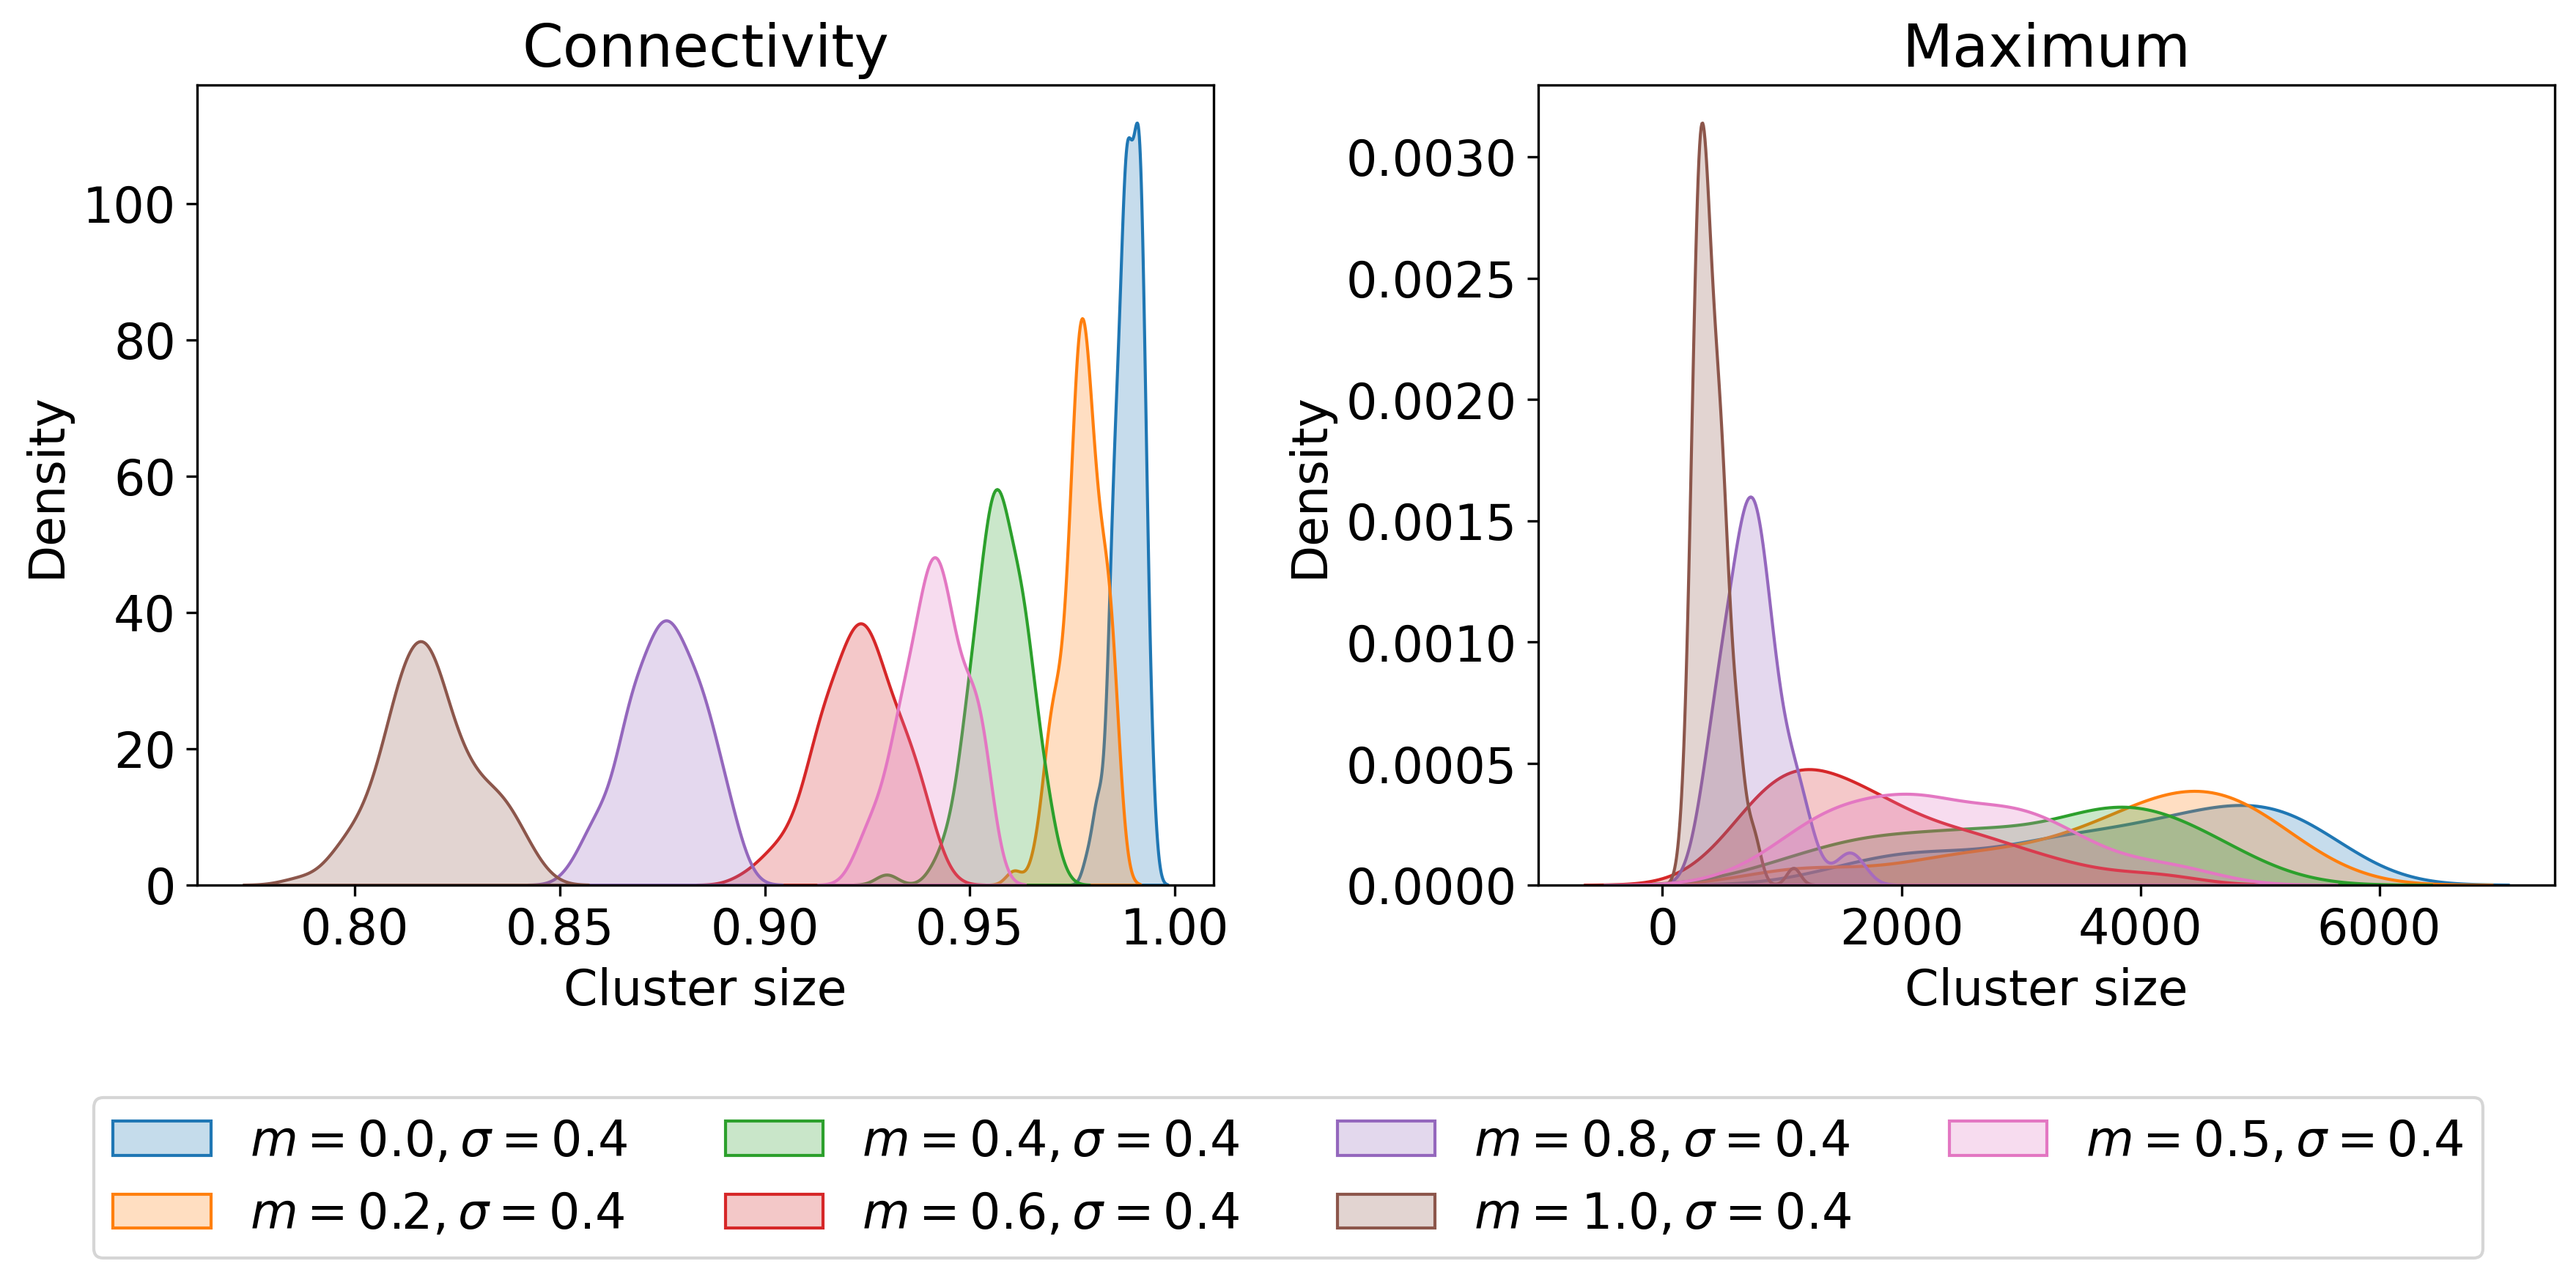

In [15]:
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12, 5))

methods = ("connectivity", "maximum")
limits = ([0.6, 1.1], None)
for method, axis, lim in zip(methods, ax.flatten(), limits):
    for key in resultsBlocks.keys():
        if key in ("Uniform(0.25, 0.75)", "Uniform(0.5, 1.0)"):
            continue
        if ".2)" in key: continue
        
        sns.kdeplot(getattr(resultsBlocks[key]["+"], method), label=get_label(key) if method != "connectivity" else None, ax=axis,
                   fill=True)
        #axis.set_xlim(lim)
        #axis.set_ylim([0, 200])
        #axis.legend()
        axis.set_xlabel("Cluster size")
        axis.set_title(method.capitalize())
        
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -.005), ncol=4)
plt.gcf().set_dpi(300)
plt.rcParams.update({'font.size': 16})
plt.tight_layout()

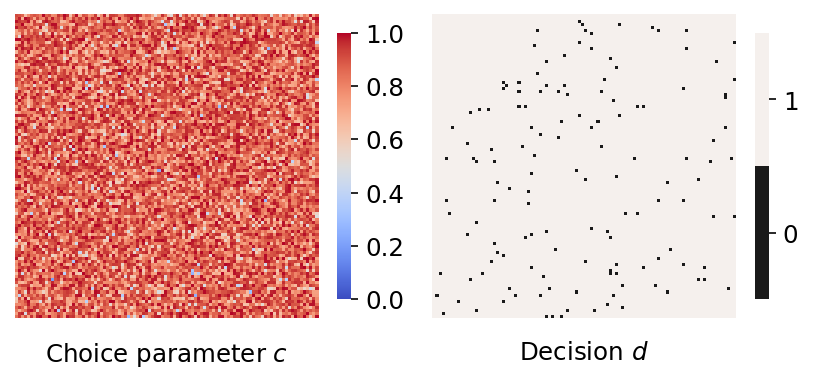

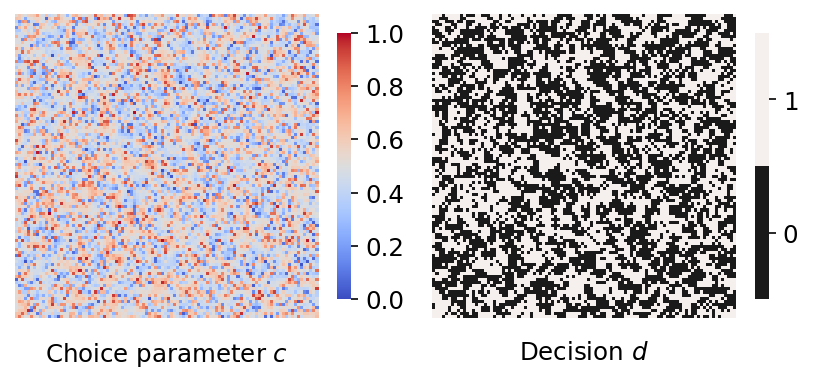

In [346]:
file = "../data/distributions/agent_data_1000steps_a-normal-10-02.csv"
data = LoadSimulation(file, columns=columns)
data = data.query("seed == 151")
ShowState(Grid(Avantgarde(data, 0)))
ShowState(Grid(Choice(data, 1000)))

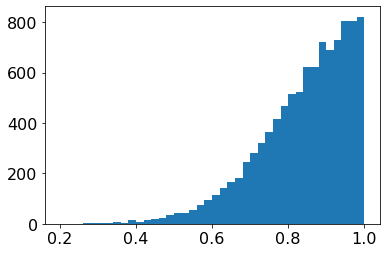

In [302]:
plt.hist(Avantgarde(data, 0), bins=40)
plt.show()

In [280]:
results["Normal(0.5, 0.2)"]

{'+': ClusterProperties(maximum=array([ 625.,  329.,  296.,  441.,  786.,  428.,  623.,  392.,  392.,
         273.,  267.,  265.,  259.,  400.,  334.,  404.,  384.,  282.,
         359.,  477.,  379.,  386.,  303.,  645.,  400.,  296.,  328.,
         357.,  304.,  283.,  326.,  478.,  329.,  318.,  255.,  293.,
         418.,  445.,  356.,  300.,  352.,  479.,  195.,  483.,  291.,
        1096.,  396.,  482.,  411.,  319.,  365.,  266.,  369.,  487.,
         351.,  528.,  426.,  575.,  330.,  266.,  492.,  489.,  752.,
         258.,  300.,  556.,  523.,  513.,  325.,  742.,  501.,  293.,
         184.,  334.,  541.,  343.,  338.,  283.,  493.,  433.,  317.,
         607.,  462.,  623.,  286.,  480.,  206.,  253.,  637.,  404.,
         414.,  480.,  382.,  260.,  504.,  314.,  530.,  552.,  653.,
         331.]), minimum=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 

In [106]:
# Cluster size dependence on avantgarde mean / variance

avantgarde_dist = dict()
for _file, dist in files:
    if distribution in avantgarde_dist.keys():
        print("Distribution %s already existent." % distribution)
    elif not os.path.exists(_file):
        print("File %s not found." % _file)
    else:
        _data = LoadSimulation(_file, columns=columns)
        _sample = _data.query("seed == 100")
        _avantgarde = Avantgarde(_sample, 0)
        _true = _avantgarde > 2. / 3
        x = np.sum(_true) / _true.size
        avantgarde_dist[dist] = (np.mean(_avantgarde[_true]) * x, 0)
        
        #(np.mean(_avantgarde), np.var(_avantgarde))
    

In [98]:
avantgarde_dist

{'Normal(0.0, 0.2)': (nan, 0),
 'Normal(0.2, 0.2)': (0.0003833707000508146, 0),
 'Normal(0.4, 0.2)': (0.005645892258399833, 0),
 'Normal(0.6, 0.2)': (0.04303389440500474, 0),
 'Normal(0.8, 0.2)': (0.1708907461589462, 0),
 'Normal(1.0, 0.2)': (0.3657232748497367, 0),
 'Normal(0.0, 0.4)': (0.012302802656866929, 0),
 'Normal(0.2, 0.4)': (0.024271952437288823, 0),
 'Normal(0.4, 0.4)': (0.04578720199886661, 0),
 'Normal(0.6, 0.4)': (0.08518885950880914, 0),
 'Normal(0.8, 0.4)': (0.129799687647785, 0),
 'Normal(1.0, 0.4)': (0.1912250191952035, 0),
 'Normal(0.5, 0.2)': (0.017647293469780046, 0),
 'Normal(0.5, 0.4)': (0.0651939430184464, 0),
 'Uniform(0.25, 0.75)': (nan, 0),
 'Uniform(0.5, 1.0)': (0.18250240862439368, 0)}

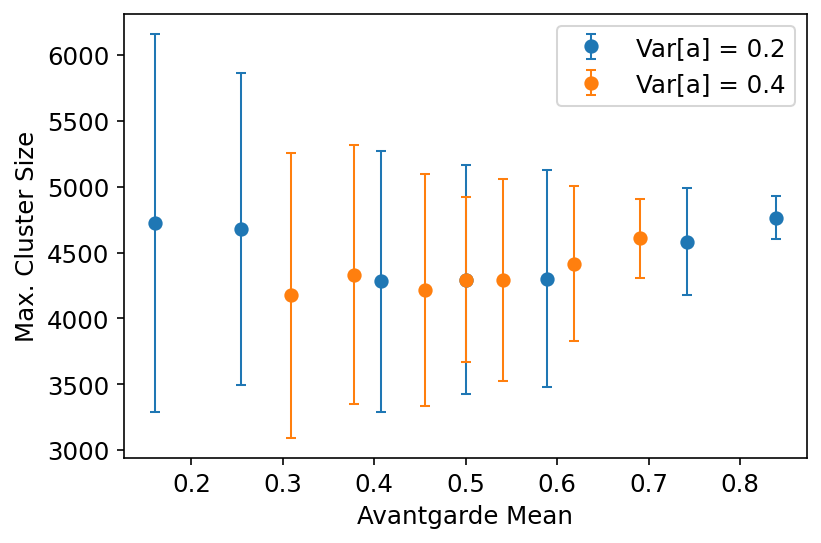

In [74]:
# plot data
x04, y04, err04 = [], [], []
x02, y02, err02 = [], [], []
xu, yu, erru = [], [], []
for _dist, _cluster in results.items():
    if "0.4)" in _dist and "Normal" in _dist:
        x04.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        y04.append(_cluster["+"].maximum.mean())
        err04.append(_cluster["+"].maximum.std())
    elif "0.2)" in _dist and "Normal" in _dist:
        x02.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        y02.append(_cluster["+"].maximum.mean())
        err02.append(_cluster["+"].maximum.std())
    else:
        xu.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yu.append(_cluster["+"].maximum.mean())
        erru.append(_cluster["+"].maximum.std())

plt.figure(figsize=(6, 4))

plt.errorbar(x02, y02, yerr=err02,
             linestyle="", marker="o", elinewidth=1., capsize=2.5, color="tab:blue",
             label="Var[a] = 0.2")
plt.errorbar(x04, y04, yerr=err04,
             linestyle="", marker="o", elinewidth=1., capsize=2.5, color="tab:orange",
             label="Var[a] = 0.4")
# plt.errorbar(xu, yu, yerr=erru,
#              linestyle="", marker="o", elinewidth=1., capsize=2.5, color="tab:red",
#              label="Uniform")

plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Avantgarde Mean")
plt.ylabel("Max. Cluster Size")

plt.legend()
plt.show()

Constant(0.1)
Constant(0.2)
Constant(0.3)
Constant(0.4)
Constant(0.5)
Constant(0.6)
Constant(0.7)
Constant(0.8)
Constant(0.9)
Constant(1.0)
Constant(0.0)


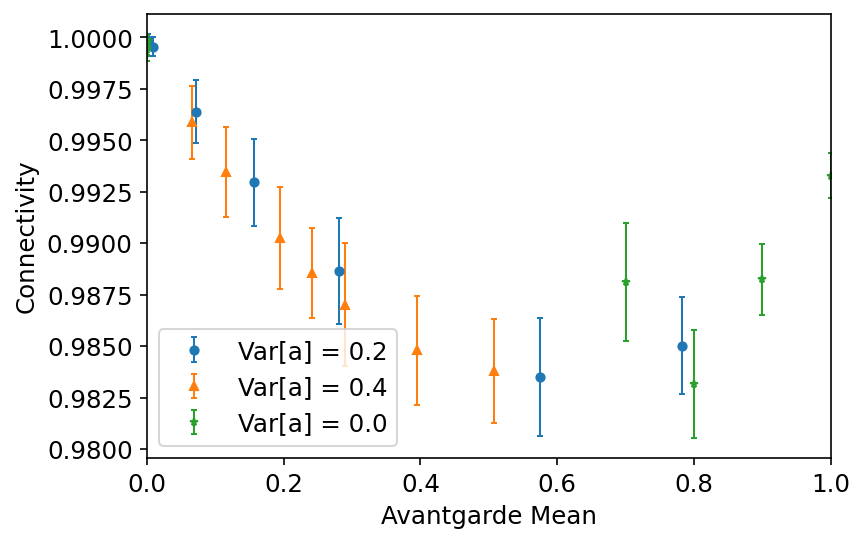

In [108]:
# plot Connectivity
x04, y04, err04 = [], [], []
x02, y02, err02 = [], [], []
xu, yu, erru = [], [], []
xc, yc, errc = [], [], []
for _dist, _cluster in results.items():
    if "Normal" in _dist:
        if "0.4)" in _dist:
            x04.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y04.append(_cluster["+"].connectivity.mean())
            err04.append(_cluster["+"].connectivity.std())
        elif "0.2)" in _dist:
            x02.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y02.append(_cluster["+"].connectivity.mean())
            err02.append(_cluster["+"].connectivity.std())
    elif "Constant" in _dist:
        print(_dist)
        xc.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yc.append(_cluster["+"].connectivity.mean())
        errc.append(_cluster["+"].connectivity.std())
    else:
        xu.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yu.append(_cluster["+"].connectivity.mean())
        erru.append(_cluster["+"].connectivity.std())

plt.figure(figsize=(6, 4))

plt.errorbar(x02, y02, yerr=err02,
             linestyle="", marker="o", ms=4, elinewidth=1., capsize=1.5, color="tab:blue",
             label="Var[a] = 0.2")
plt.errorbar(x04, y04, yerr=err04,
             linestyle="", marker="^", ms=4, elinewidth=1., capsize=1.5, color="tab:orange",
             label="Var[a] = 0.4")
plt.errorbar(xc, yc, yerr=errc,
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5, color="tab:green",
             label="Var[a] = 0.0")
# plt.errorbar(xu, yu, yerr=erru,
#              linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:red",
#              label="Uniform")

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Avantgarde Mean")
plt.ylabel("Connectivity")

plt.show()

In [19]:
resultsBlocks

{'Normal(0.0, 0.2)': {'+': ClusterProperties(maximum=array([4061., 4812., 3729., 6660., 5238., 3553., 5929., 3972., 4195.,
         6255., 3879., 4181., 3776., 4123., 1544., 3604., 6272., 1275.,
         5488., 6086., 4082., 5038.,  675., 6060., 4565., 3384., 5251.,
         2802., 5807., 3298., 5299., 4941., 5890., 6457., 5046., 6564.,
         4828., 5167., 4071., 3892., 7599., 4578., 5612., 2187., 3129.,
         5720., 4890., 4308., 4221., 5533., 4735., 4338., 5296., 5558.,
         4439., 3243., 2638., 4891., 4225., 6739., 7341., 5206., 4539.,
         6461., 5141., 1603., 5157., 2088., 7013., 6021., 4607., 4277.,
         5471., 2760., 5071., 5789., 5800., 3458., 3808., 3326., 5289.,
         5093., 5666., 6946., 6420., 3568., 3962., 3980., 1278., 5630.,
         6781., 5732., 6155., 2260., 5136., 4901., 5774., 7092., 3451.,
         6511.]), minimum=array([1.000e+00, 4.812e+03, 1.000e+00, 6.660e+03, 5.238e+03, 3.100e+01,
         5.929e+03, 3.972e+03, 1.000e+00, 1.000e+00, 1.000

In [83]:
avantgarde_dist["Constant(0.0)"] = (0, 0)

Uniform(0.25, 0.75)
Uniform(0.5, 1.0)
Constant(0.0)
Constant(0.1)
Constant(0.2)
Constant(0.3)
Constant(0.4)
Constant(0.5)
Constant(0.6)
Constant(0.7)
Constant(0.8)
Constant(0.9)
Constant(1.0)


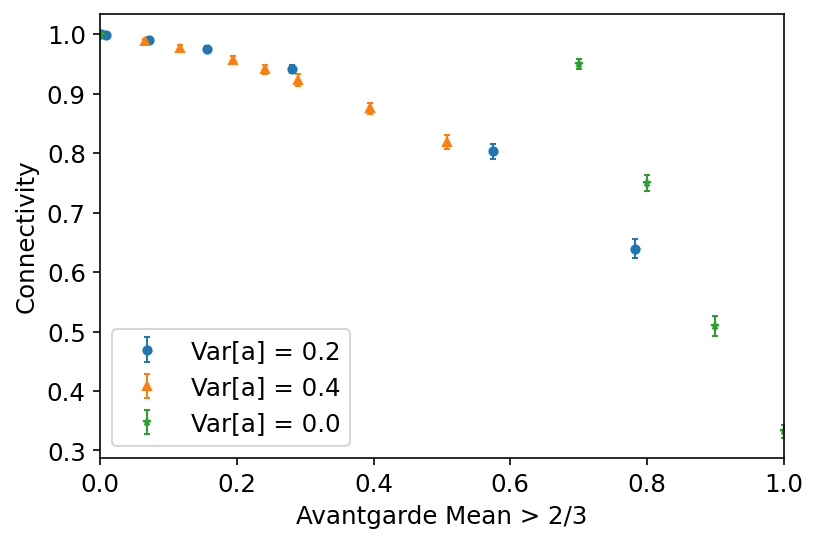

In [110]:
# plot Connectivity
x04, y04, err04 = [], [], []
x02, y02, err02 = [], [], []
xu, yu, erru = [], [], []
xc, yc, errc = [], [], []
for _dist, _cluster in resultsBlocks.items():
    if "Normal" in _dist:
        if "0.4)" in _dist:
            x04.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y04.append(_cluster["+"].connectivity.mean())
            err04.append(_cluster["+"].connectivity.std())
        elif "0.2)" in _dist:
            x02.append(avantgarde_dist[_dist][0]) # mean of avantgarde
            y02.append(_cluster["+"].connectivity.mean())
            err02.append(_cluster["+"].connectivity.std())
    elif "Constant" in _dist:
        print(_dist)
        xc.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yc.append(_cluster["+"].connectivity.mean())
        errc.append(_cluster["+"].connectivity.std())
    else:
        print(_dist)
        xu.append(avantgarde_dist[_dist][0]) # mean of avantgarde
        yu.append(_cluster["+"].connectivity.mean())
        erru.append(_cluster["+"].connectivity.std())

plt.figure(figsize=(6, 4))

plt.errorbar(x02, y02, yerr=err02,
             linestyle="", marker="o", ms=4, elinewidth=1., capsize=1.5, color="tab:blue",
             label="Var[a] = 0.2")
plt.errorbar(x04, y04, yerr=err04,
             linestyle="", marker="^", ms=4, elinewidth=1., capsize=1.5, color="tab:orange",
             label="Var[a] = 0.4")
plt.errorbar(xc, yc, yerr=errc,
             linestyle="", marker="*", ms=4, elinewidth=1., capsize=1.5, color="tab:green",
             label="Var[a] = 0.0")
# plt.errorbar(xu, yu, yerr=erru,
#              linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:red",
#              label="Uniform")

plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.gcf().set_dpi(147)
plt.rcParams.update({'font.size': 12})
plt.xlabel("Avantgarde Mean > 2/3")
plt.ylabel("Connectivity")

plt.show()

In [76]:
aa = np.linspace(0.01, 1.0, 100)
keys = [*range(1, 20)]

# init cluster props
all_props_pos = [ClusterProperties() for a in aa[:]]
all_props_neg = [ClusterProperties() for a in aa[:]]
    
for k in keys:
    columns = ['id','avantgarde', 'affinity', 'affinityGoal', 'step']
    file = f"../data/constant_avantgarde/agent_data_800steps_{k}.csv"
    data = LoadSimulation(file, columns)
    step = 800
    
    for j, a in enumerate(aa[:]):
        a = np.round(a, 2)

        # >--- get cluster sizes
        grid_data = Grid(Choice(data.query("avantgarde == @a"), step))
        labeled_data = np.digitize(grid_data, bins=np.arange(0, 1, 0.5))
        clusters = CountSizes(labeled_data, skip_size=1, corner_neighbours=False)
        # ---<
        
        # save data
        AddClusterProperties(all_props_neg[j], clusters[1])
        AddClusterProperties(all_props_pos[j], clusters[2])


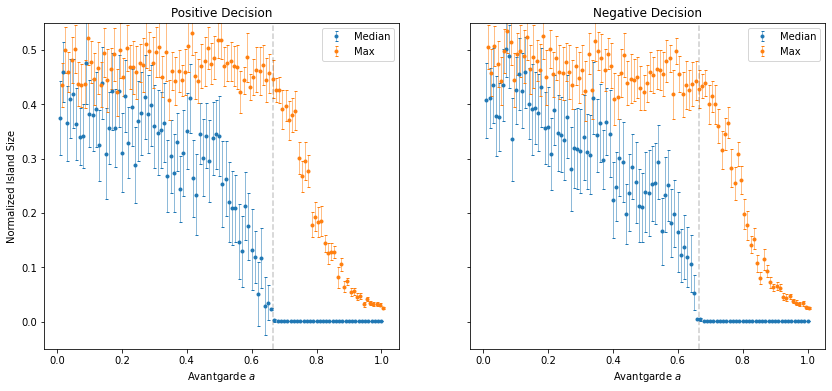

In [77]:
# prepare data
N = 10000
scale = 1.0 / N

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

data = (all_props_pos, all_props_neg)

for ax, all_props in zip(axes, data):
    
    x = np.array(aa)
    y = np.array([np.mean(c.median) for c in all_props]) * scale
    std = np.array([np.std(c.median) for c in all_props]) * scale / np.sqrt(10)

    xmax = np.array(aa)
    ymax = np.array([np.mean(c.maximum) for c in all_props]) * scale
    stdmax = np.array([np.mean(c.maximum) for c in all_props]) * scale / np.sqrt(10)
    
    ax.errorbar(x[::], y[::], yerr=err[::1], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:blue",
             label="Median")

    ax.errorbar(xmax[::]+0.005, ymax[::], yerr=errmax[::], 
             linestyle="", marker=".", elinewidth=0.5, capsize=1.5, color="tab:orange",
             label="Max")
#plt.plot(x, y)

    ymin, ymax = -0.1 / 2, 1.1 / 2
    ax.vlines(2./3, ymin, ymax, colors="black", linestyles="dashed", alpha=0.2)

    ax.set_ylim([ymin, ymax])

    ax.legend()
    
    ax.set_xlabel(r"Avantgarde $a$")

axes[0].set_ylabel("Normalized Island Size")

axes[0].title.set_text("Positive Decision")
axes[1].title.set_text("Negative Decision")

plt.show()

Computing embedding
Done.
ward :	0.16s
average :	0.07s
complete :	0.08s
single :	0.03s


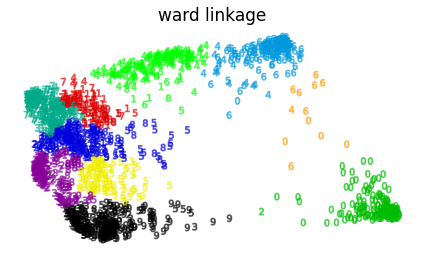

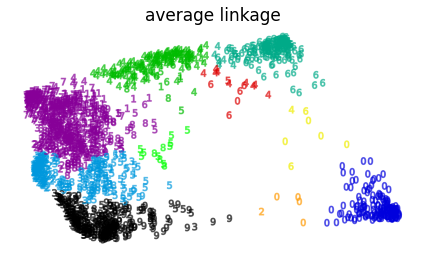

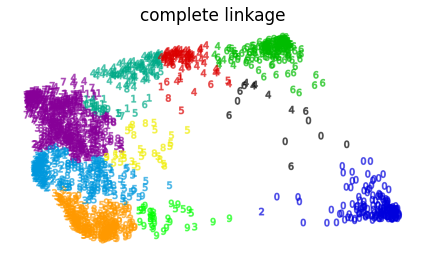

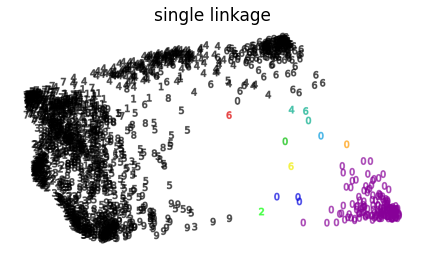

In [1]:
# Authors: Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2014

from time import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn import manifold, datasets

digits = datasets.load_digits()
X, y = digits.data, digits.target
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)

    plt.figure(figsize=(6, 4))
    for digit in digits.target_names:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=50,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = manifold.SpectralEmbedding(n_components=2).fit_transform(X)
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=10)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

In [36]:
file = "../data/distributions/agent_data_1000steps_a-normal-04-04.csv"
data = LoadSimulation(file, columns=columns)

islands = np.digitize(Grid(Choice(sample, 1000)), bins=np.arange(0, 1, 0.5))

In [71]:
X, y = [], []
L = 100
with np.nditer(islands, flags=["multi_index"])as it:
    for x in it:
        X.append([*it.multi_index])
        y.append(x)
    X = np.array(X) * 1./100
    y = np.array(y)

In [72]:
np.array(y)

array([1, 2, 2, ..., 2, 1, 1], dtype=int64)

Computing embedding
Done.
ward :	1.77s
[231 231 231 ...  24  24  24]
average :	1.43s
[ 4  4  4 ... 12 12 12]
complete :	1.37s
[37 37 37 ... 54 54 54]
single :	0.47s
[0 0 0 ... 0 0 0]


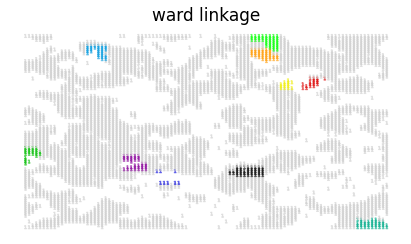

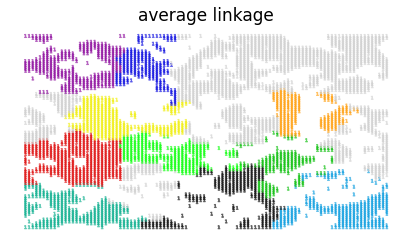

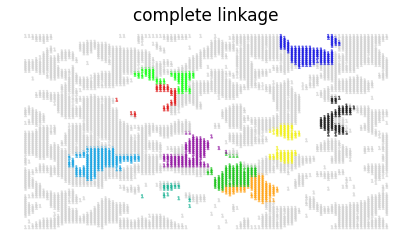

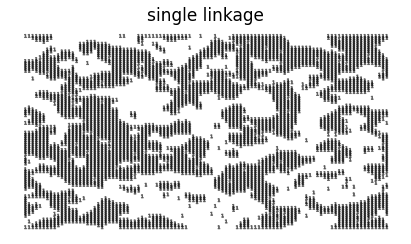

In [98]:
n_samples, n_features = X.shape

np.random.seed(0)


# ----------------------------------------------------------------------
# Visualize the clustering
def plot_clustering(X_red, labels, title=None):
    x_min, x_max = np.min(X_red, axis=0), np.max(X_red, axis=0)
    X_red = (X_red - x_min) / (x_max - x_min)
    
    print(labels)
    plt.figure(figsize=(6, 4))
    for digit in [1]:
        plt.scatter(
            *X_red[y == digit].T,
            marker=f"${digit}$",
            s=10,
            c=plt.cm.nipy_spectral(labels[y == digit] / 10),
            alpha=0.5,
        )

    plt.xticks([])
    plt.yticks([])
    if title is not None:
        plt.title(title, size=17)
    plt.axis("off")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])


# ----------------------------------------------------------------------
# 2D embedding of the digits dataset
print("Computing embedding")
X_red = X
print("Done.")

from sklearn.cluster import AgglomerativeClustering

for linkage in ("ward", "average", "complete", "single"):
    clustering = AgglomerativeClustering(linkage=linkage, n_clusters=None, compute_full_tree=True, distance_threshold=0.2)
    t0 = time()
    clustering.fit(X_red)
    print("%s :\t%.2fs" % (linkage, time() - t0))

    plot_clustering(X_red, clustering.labels_, "%s linkage" % linkage)


plt.show()

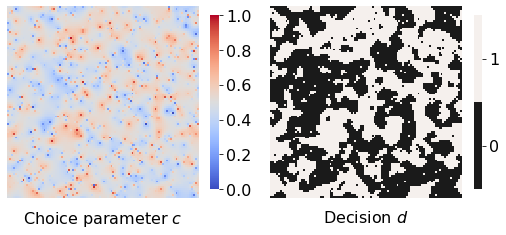

In [94]:
ShowState(Grid(Choice(sample, 1000)).T)

In [191]:
def RowIndex(i, n_columns): 
    return i % n_columns

def ColIndex(i, n_rows): 
    return i % n_rows

def AddCorner(r, c, i, j, data, to_visit):
    Ni = data.shape[0]
    Nj = data.shape[1]
    if data[i, j] != data[RowIndex(i+r, Ni), ColIndex(j+c, Nj)]:
        return
    if data[i, ColIndex(j+c, Nj)] == data[i, j] or data[RowIndex(i+r, Ni), j] == data[i, j]:
        to_visit.append([RowIndex(i+r, Ni), ColIndex(j+c, Nj)])


    
to_visit = []
CheckBlock(-1, 1, 0, 1, np.array([[1, 2, 1],[1, 1, 1], [1, 2, 2]]), to_visit)

to_visit

[[2, 2], [2, 1]]

In [193]:
def CheckBlock(r, c, i, j, data, to_visit):
    Ni = data.shape[0]
    Nj = data.shape[1]
    v = data[i, j]
    ij_others = np.array([[RowIndex(i+r, Ni), ColIndex(j+c, Nj)],
                 [RowIndex(i+r, Ni), j],
                 [i, ColIndex(j+c, Nj)]])
    v_others = np.array([data[_i, _j] for _i, _j in ij_others])
    ij_good = ij_others[v_others == v]
    if ij_good.shape[0] > 1:
        to_visit.extend(ij_good.tolist())

def DFS_strong(i, j, data, visited, value=0, corner_neighbours=True):
    
    nodes_to_visit = [[i, j]]
    size = 0
    
    if visited[i, j] or data[i, j] != value:
        return size
    
    if corner_neighbours:
        rowNeighbours = [-1, -1, -1, 0, 0, 1, 1, 1] # [-1, 0, 0, 1] #
        columnNeighbours = [-1, 0, 1, -1, 1, -1, 0, 1] # [0, -1, 1, 0] #
    else:
        rowNeighbours = [-1, 0, 0, 1] #
        columnNeighbours = [0, -1, 1, 0] #
    
    while len(nodes_to_visit) > 0:
        i, j = nodes_to_visit[0]
        
        if not visited[i, j] and data[i, j] == value:
            
            CheckBlock(-1, -1, i, j, data, nodes_to_visit)
            CheckBlock(-1, 1, i, j, data, nodes_to_visit)
            CheckBlock(1, -1, i, j, data, nodes_to_visit)
            CheckBlock(1, 1, i, j, data, nodes_to_visit)
                
            size += 1
            
        visited[i, j] = 1
        nodes_to_visit.pop(0)
    
    return size

def CountSizes(data, skip_size=0, corner_neighbours=False):
    counts = {key: [] for key in np.unique(data.flatten())}
    dwarfs = []
    for c in counts.keys():
        visited = np.zeros(data.shape)
        for i in range(data.shape[0]):
            for j in range(data.shape[1]):
                size = DFS_strong(i, j, data, visited, value=c, corner_neighbours=corner_neighbours)
                if size > skip_size:
                    counts[data[i, j]].append(size)
                elif size > 0:
                    dwarfs.append(size)
    return counts, dwarfs

counts, skipped = CountSizes(islands, skip_size=0, corner_neighbours=False)
print(counts)

{1: [21, 8, 13, 3, 11, 89, 48, 7, 13, 1, 12, 1, 102, 1, 95, 1, 3, 61, 44, 1, 6, 1, 13, 1, 36, 4, 1, 1, 1, 24, 13, 6, 1, 1, 1, 4, 1, 1, 6, 1, 1, 5, 1, 1, 5, 4, 1, 1, 1, 1, 3, 1, 1, 1, 8, 1, 1, 1, 1, 1, 3, 1, 1, 6, 9, 3, 6, 1, 1, 1, 1, 3, 18, 1, 31, 1, 1, 1, 4, 1, 1, 1, 1, 1, 34, 1, 1, 5, 1, 1, 1, 4, 5, 1, 4, 82, 1, 1, 1, 1, 1, 1, 1, 1, 6, 1, 1, 4, 1, 1, 17, 1, 1, 1, 1, 6, 1, 1, 1, 5, 1, 1, 8, 1, 1, 1, 1, 1, 30, 19, 1, 1, 4, 1, 1, 1, 32, 1, 1, 1, 1, 1, 1, 7, 1, 1, 6, 1, 1, 1, 1, 1, 1, 1, 1, 8, 32, 44, 1, 6, 4, 1, 1, 1, 1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 42, 1, 1, 1, 9, 1, 1, 1, 1, 7, 1, 1, 1, 8, 11, 1, 9, 5, 1, 6, 1, 1, 5, 1, 1, 1, 1, 75, 1, 1, 1, 11, 60, 1, 1, 1, 19, 1, 1, 8, 1, 1, 1, 1, 17, 1, 1, 1, 1, 3, 1, 1, 1, 6, 1, 6, 1, 1, 10, 5, 4, 1, 1, 1, 1, 1, 1, 1, 1, 25, 1, 3, 1, 1, 18, 1, 1, 1, 1, 26, 3, 4, 1, 1, 24, 1, 1, 1, 9, 4, 1, 1, 7, 6, 1, 1, 34, 1, 3, 1, 1, 1, 14, 1, 1, 6, 7, 1, 1, 1, 7, 1, 1, 1, 1, 84, 1, 1, 1, 95, 1, 1, 29, 1, 1, 1, 9, 1, 10, 1, 

C:\Users\hoedtke\AppData\Local\Temp/ipykernel_3180/3632923914.py:2: RuntimeWarning: invalid value encountered in double_scalars
  return (a1 * b1 + (1-a1)*a2*b2)/(a1 + a2 - a1*a2)


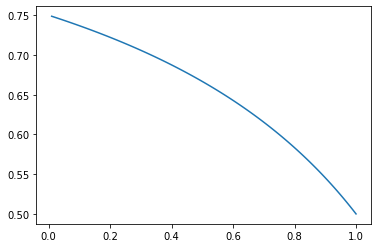

In [39]:
def c1(a1, a2, b1, b2):
    return (a1 * b1 + (1-a1)*a2*b2)/(a1 + a2 - a1*a2)

b1, b2 = 0.5, 1.0
aa = np.linspace(0, 1, 100)
c1 = [c1(a, a, b1, b2) for a in aa]

plt.figure()
plt.plot(aa, c1)
plt.show()

In [ ]:
c1(1, 1,)